# Section 2: Analyzing Causal Forests on Simulated Data similar to GSS data 

In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from tqdm.auto import tqdm

from copy import deepcopy
import joblib
import warnings
warnings.filterwarnings("ignore")

def fullDisplay():
    pd.set_option("display.max_rows", None, "display.max_columns", None)

def defaultDisplay():
    pd.reset_option('^display.', silent=True)

## Loading data

In [2]:
welfare = pd.read_csv("Data/welfare_clean.csv", low_memory=False)
treatments = welfare['w']
labels = welfare['y']
welfare.drop(columns=['w', 'y'], inplace=True)
welfare

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss,attblack,attblack_miss
0,0,1,7,0.004845,0.005228,1,135,0.005641,2,2,...,0,0,0,0,0,0,0,0,0.005440,0
1,0,2,1,0.005055,0.005228,0,106,0.006538,2,2,...,0,1,0,0,1,0,0,0,0.004080,0
2,0,3,7,0.004845,0.005228,1,99,0.006538,2,2,...,0,1,0,0,0,0,0,0,0.002040,0
3,0,4,3,0.005055,0.005228,0,142,0.004615,2,0,...,0,0,0,0,1,0,0,0,0.004080,0
4,0,5,8,0.005055,0.005228,1,211,0.005171,2,1,...,0,0,0,0,0,0,0,0,0.004080,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,15,2040,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.004080,0
36497,15,2041,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.006120,0
36498,15,2042,7,0.004845,0.005228,1,211,0.005171,2,2,...,0,1,0,0,0,1,0,0,0.004080,0
36499,15,2043,7,0.005935,0.005228,1,211,0.005171,2,2,...,0,1,0,0,1,1,0,0,0.005021,1


## DGP, Estimation, and Evaluation functions

In [1]:
def dgp(welfare, effect_type="heterogeneous", effect_homogeneous=10, effect_heterogeneous=2,
        treatment_type="binary", treatment_probability=0.5, heterogeneous_select=4, overlap=True,
        overlap_percent=0.5, order=3, linearity="med", N=5000, treatment_cutoff_val=0.0):    
    
    featureNames = list(welfare.columns)

    # Define non-confounders
    importantFeatureNames = ['wrkstat', 'race', 'year', 'hrs1', 'income', 'occ80', 'id', 'educ'] # top 8 important features based on Shapley visualization from 
    importantFeatureIndices = []
    for name in importantFeatureNames:
        importantFeatureIndices.append(featureNames.index(name)) 

    # Error terms
    error = np.random.normal(size=(N,1))

    # Data generation
    cov = welfare.cov()
    means = welfare.mean(axis=0)
    X = np.random.multivariate_normal(means.values, cov, size=N, check_valid='warn', tol=1e-8)

    # Linearity specification
    if linearity != 'full':
        select = 0 # select n most important features for interactions and polynomials
        poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)

        if linearity == "high": 
            select = 2
        elif linearity == "med": 
            select = 4
        elif linearity == "low": 
            select = 8
        else: # if some typo, assume baseline of high
            select = 2

        poly.fit(X[:, importantFeatureIndices[:select]])
        fullData = poly.transform(X[:, importantFeatureIndices[:select]])
        fullNames = poly.get_feature_names(input_features=importantFeatureNames[:select])
        higherData = fullData[:, -(fullData.shape[1] - select):] # select only higher order
        higherNames = fullNames[-(len(fullNames) - select):]

        X = np.append(X, higherData, axis=1) 
        featureNames.extend(list(higherNames))

    # Treatment selection
    if treatment_type == "binary":
        # randomly assigned treatments with propensity treatment_probability
        treatments = np.random.choice([0, 1], size=N, p=[1 - treatment_probability, treatment_probability]).reshape((-1, 1))
        if not overlap:
            forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
            treatments[forced] = 0
        treated = treatments > 0

        # generate counterfactual treatment indicator vector
        c_treatments = deepcopy(treatments)
        c_treatments[treatments == 0] = 1
        c_treatments[treatments == 1] = 0
    else:
        treatments = np.random.uniform(size=(N, 1))
        if not overlap:
            forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
            treatments[forced] = 0
        
        # set all treatment values close to 0 to 0
        for idx, val in enumerate(treatments):
            if math.isclose(val, 0, abs_tol=0.1):
                treatments[idx] = 0

        treated = treatments > treatment_cutoff_val

        # to-do: counterfactual treatment vector
        c_treatments = deepcopy(treatments)
        c_treatments[treatments > treatment_cutoff_val] = 0
        c_treatments[treatments == 0] = treatments.mean()

    # Treatment effect calculation
    if effect_type == "homogeneous":

        T = treatments*effect_homogeneous
        CT = c_treatments*effect_homogeneous

    else: 
        # heterogeneous treatment is effect 1 + effect * (sum of first heterogeneous_select important variables)
        heterogeneousIndices = importantFeatureIndices[:heterogeneous_select]

        T = 1 + (effect_heterogeneous*(X[:, heterogeneousIndices].sum(axis=1)))*treatments.ravel()
        T = T.reshape(-1, 1)
        T[~treated] = np.zeros((~treated).sum())
        
        # counterfactual effect
        CT = 1 + (effect_heterogeneous*(X[:, heterogeneousIndices].sum(axis=1)))*c_treatments.ravel()
        CT = CT.reshape(-1, 1)
        CT[treated] = np.zeros((treated).sum()) # everyone that was treated goes to untreated in counterfactual

    # Coefficients calculation
    betas = np.random.normal(size=X.shape[1]).reshape(-1,1)
    # draw from diff distribution for "important" features
    if_coef_mean = 7 # important features mean 
    if_coef_var = 1 # ... var
    betas[importantFeatureIndices] = np.random.normal(if_coef_mean, if_coef_var, size=len(ifi)).reshape(-1, 1)
        
    # Outcome calculation
    y = T + X@betas + error
    cy = CT + X@betas + error
    
    # ATE calculation
    empirical_treated = y[treated] - cy[treated] # the treated (in y)
    empirical_untreated = cy[~treated] - y[~treated] # the untreated
    ate = (empirical_treated.mean() + empirical_untreated.mean())/2
    
    return y, X, betas, featureNames, treatments, cy, ate, importantFeatureIndices

def estimate_cf(y, X, treatments, test_size=0.2, criterion='het', cv=5, discrete_treatment=True, n_estimators=1000):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForestDML(criterion=criterion, 
                            n_estimators=n_estimators,       
                            max_samples=0.5,
                            discrete_treatment=discrete_treatment,
                            honest=True,
                            inference=True,
                            cv=cv)
    # fit model
    est.fit(Y_train, T_train, X=X_train, W=None)
        
    return est, X_test

In [19]:
# compute evaluation stats over K simulations
def evalStats(estimators, trueATES, evalSets):
    K = len(estimators)

    lbs = np.zeros(K)
    ubs = np.zeros(K)
    ates = np.zeros(K)
    
    totalBias = 0
    totalRMSE = 0
    totalCoverage = 0
    totalInterval = 0

    for i in range(K):
        estimateATE = estimators[i].ate(evalSets[i])[0]
        lb, ub = estimators[i].ate_interval(evalSets[i], alpha=0.05)
        lbs[i] = lb
        ubs[i] = ub
        ates[i] = estimateATE
        
        bias = abs(trueATES[i] - estimateATE)
        totalBias += bias
        
        rmse = bias**2
        totalRMSE += rmse

        coverage = 1 if (trueATES[i] >= lb and trueATES[i] <= ub) else 0
  
        totalCoverage += coverage

        interval = ub - lb
        totalInterval += interval
    
    return totalBias / K, (totalRMSE / K)**0.5, totalCoverage / K, totalInterval / K, lbs, ubs, ates

## (1) Sample Size

In [51]:
K = 10
Ns = [1000, 5000, 10000]

biasNs = np.zeros(len(Ns))
rmseNs = np.zeros(len(Ns))
coverageNs = np.zeros(len(Ns))
intervalNs = np.zeros(len(Ns))
lbsNs = np.zeros((len(Ns), K))
ubsNs = np.zeros((len(Ns), K))
atesNs = np.zeros((len(Ns), K))

for idx, N in enumerate(Ns):
    estNs = []
    trueATENs = []
    evalSetNs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, N=N)
        est, X_test = estimate_cf(y, X, treatments)

        estNs.append(est)
        trueATENs.append(ate)
        evalSetNs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estNs, trueATENs, evalSetNs)
    
    biasNs[idx] = bias
    rmseNs[idx] = rmse
    coverageNs[idx] = coverage
    intervalNs[idx] = interval
    lbsNs[idx, :] = lbs
    ubsNs[idx, :] = ubs
    atesNs[idx, :] = ates

joblib.dump(biasNs, 'Results/biasNs.pkl')
joblib.dump(rmseNs, 'Results/rmseNs.pkl')
joblib.dump(coverageNs, 'Results/coverageNs.pkl')
joblib.dump(intervalNs, 'Results/intervalNs.pkl')

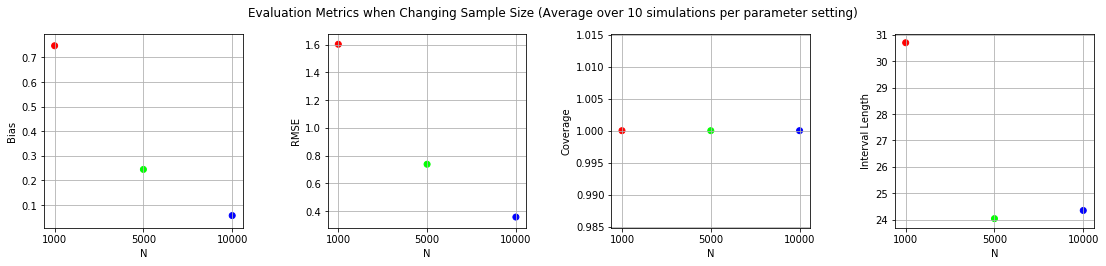

In [29]:
biasNs = joblib.load('Results/biasNs.pkl')
rmseNs = joblib.load('Results/rmseNs.pkl')
coverageNs = joblib.load('Results/coverageNs.pkl')
intervalNs = joblib.load('Results/intervalNs.pkl')

xNs = list(map(str, Ns))
cNs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xNs, biasNs, c=cNs/255)
axs[0].set(xlabel='N', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xNs, rmseNs, c=cNs/255)
axs[1].set(xlabel='N', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xNs, coverageNs, c=cNs/255)
axs[2].set(xlabel='N', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xNs, intervalNs, c=cNs/255)
axs[3].set(xlabel='N', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Sample Size (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [18]:
data = {'Bias':biasNs, 'RMSE':rmseNs, 'Coverage':coverageNs, 'Interval Length':intervalNs}
tableNs = pd.DataFrame(data=data, index=xNs)
tableNs

,Bias,RMSE,Coverage,Interval Length
1000,0.746836,1.603785,1.0,30.696936
5000,0.244467,0.737080,1.0,24.038016
10000,0.056971,0.355563,1.0,24.345317


## (2) Degree of Non-linearity in X

In [23]:
K = 10
linearityLevels = ['full', 'high', 'med', 'low']

biasLLs = np.zeros(len(linearityLevels))
rmseLLs = np.zeros(len(linearityLevels))
coverageLLs = np.zeros(len(linearityLevels))
intervalLLs = np.zeros(len(linearityLevels))

for idx, level in enumerate(linearityLevels):
    estLLs = []
    trueATELLs = []
    evalSetLLs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, linearity=level)
        est, X_test = estimate_cf(y, X, treatments)

        estLLs.append(est)
        trueATELLs.append(ate)
        evalSetLLs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estLLs, trueATELLs, evalSetLLs)
    
    biasLLs[idx] = bias
    rmseLLs[idx] = rmse
    coverageLLs[idx] = coverage
    intervalLLs[idx] = interval

joblib.dump(biasLLs, 'Results/biasLLs.pkl')
joblib.dump(rmseLLs, 'Results/rmseLLs.pkl')
joblib.dump(coverageLLs, 'Results/coverageLLs.pkl')
joblib.dump(intervalLLs, 'Results/intervalLLs.pkl')

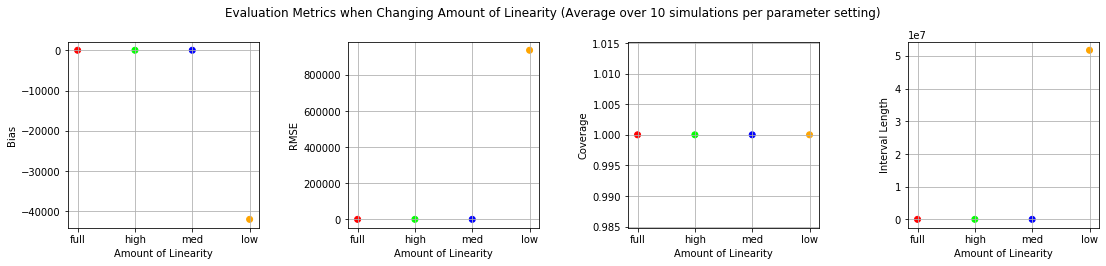

In [34]:
biasLLs = joblib.load('Results/biasLLs.pkl')
rmseLLs = joblib.load('Results/rmseLLs.pkl')
coverageLLs = joblib.load('Results/coverageLLs.pkl')
intervalLLs = joblib.load('Results/intervalLLs.pkl')

xLLs = linearityLevels
cLLs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xLLs, biasLLs, c=cLLs/255)
axs[0].set(xlabel='Amount of Linearity', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xLLs, rmseLLs, c=cLLs/255)
axs[1].set(xlabel='Amount of Linearity', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xLLs, coverageLLs, c=cLLs/255)
axs[2].set(xlabel='Amount of Linearity', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xLLs, intervalLLs, c=cLLs/255)
axs[3].set(xlabel='Amount of Linearity', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Amount of Linearity (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [33]:
data = {'Bias':biasLLs, 'RMSE':rmseLLs, 'Coverage':coverageLLs, 'Interval Length':intervalLLs}
tableLLs = pd.DataFrame(data=data, index=xLLs)
tableLLs

,Bias,RMSE,Coverage,Interval Length
full,0.217893,0.373320,1.0,1.345840e+01
high,0.240861,0.277282,1.0,1.133298e+01
med,0.120957,0.600810,1.0,2.458662e+01
low,-41966.141608,935547.071958,1.0,5.169195e+07


## (3) Percentage Treated

In [17]:
K = 10
percentTreats = [0.1, 0.5, 0.9]

biasPTs = np.zeros(len(percentTreats))
rmsePTs = np.zeros(len(percentTreats))
coveragePTs = np.zeros(len(percentTreats))
intervalPTs = np.zeros(len(percentTreats))

for idx, percent in enumerate(percentTreats):
    estPTs = []
    trueATEPTs = []
    evalSetPTs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, treatment_probability=percent)
        est, X_test = estimate_cf(y, X, treatments)

        estPTs.append(est)
        trueATEPTs.append(ate)
        evalSetPTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estPTs, trueATEPTs, evalSetPTs)
    
    biasPTs[idx] = bias
    rmsePTs[idx] = rmse
    coveragePTs[idx] = coverage
    intervalPTs[idx] = interval

joblib.dump(biasPTs, 'Results/biasPTs.pkl')
joblib.dump(rmsePTs, 'Results/rmsePTs.pkl')
joblib.dump(coveragePTs, 'Results/coveragePTs.pkl')
joblib.dump(intervalPTs, 'Results/intervalPTs.pkl')

In [ ]:
biasPTs = joblib.load('Results/biasPTs.pkl')
rmsePTs = joblib.load('Results/rmsePTs.pkl')
coveragePTs = joblib.load('Results/coveragePTs.pkl')
intervalPTs = joblib.load('Results/intervalPTs.pkl')

xPTs = list(map(str, percentTreats))
cPTs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xPTs, biasPTs, c=cPTs/255)
axs[0].set(xlabel='Percentage Treated', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xPTs, rmsePTs, c=cPTs/255)
axs[1].set(xlabel='Percentage Treated', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xPTs, coveragePTs, c=cPTs/255)
axs[2].set(xlabel='Percentage Treated', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xPTs, intervalPTs, c=cPTs/255)
axs[3].set(xlabel='Percentage Treated', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Percentage Treated (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
data = {'Bias':biasPTs, 'RMSE':rmsePTs, 'Coverage':coveragePTs, 'Interval Length':intervalPTs}
tablePTs = pd.DataFrame(data=data, index=xPTs)
tablePTs

## (4) Overlap

In [10]:
K = 10
overlapTypes = [True, False]

biasOTs = np.zeros(len(overlapTypes))
rmseOTs = np.zeros(len(overlapTypes))
coverageOTs = np.zeros(len(overlapTypes))
intervalOTs = np.zeros(len(overlapTypes))

for idx, overlap in enumerate(overlapTypes):
    estOTs = []
    trueATEOTs = []
    evalSetOTs = []
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, overlap=overlap)
        est, X_test = estimate_cf(y, X, treatments)

        estOTs.append(est)
        trueATEOTs.append(ate)
        evalSetOTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estOTs, trueATEOTs, evalSetOTs)
    
    biasOTs[idx] = bias
    rmseOTs[idx] = rmse
    coverageOTs[idx] = coverage
    intervalOTs[idx] = interval

joblib.dump(biasOTs, 'Results/biasOTs.pkl')
joblib.dump(rmseOTs, 'Results/rmseOTs.pkl')
joblib.dump(coverageOTs, 'Results/coverageOTs.pkl')
joblib.dump(intervalOTs, 'Results/intervalOTs.pkl')

In [ ]:
biasOTs = joblib.load('Results/biasOTs.pkl')
rmseOTs = joblib.load('Results/rmseOTs.pkl')
coverageOTs = joblib.load('Results/coverageOTs.pkl')
intervalOTs = joblib.load('Results/intervalOTs.pkl')

xOTs = list(map(str, overlapTypes))
cOTs = np.array([[255, 0, 0], [0, 255, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xOTs, biasOTs, c=cOTs/255)
axs[0].set(xlabel='Overlap Type', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xOTs, rmseOTs, c=cOTs/255)
axs[1].set(xlabel='Overlap Type', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xOTs, coverageOTs, c=cOTs/255)
axs[2].set(xlabel='Overlap Type', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xOTs, intervalOTs, c=cOTs/255)
axs[3].set(xlabel='Overlap Type', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Overlap (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
data = {'Bias':biasOTs, 'RMSE':rmseOTs, 'Coverage':coverageOTs, 'Interval Length':intervalOTs}
tableOTs = pd.DataFrame(data=data, index=xOTs)
tableOTs

## (5) Treatment Effect Heterogeneity Level

In [11]:
K = 10
heterogeneityLevels = [0, 2, 4, 8]

biasHLs = np.zeros(len(heterogeneityLevels))
rmseHLs = np.zeros(len(heterogeneityLevels))
coverageHLs = np.zeros(len(heterogeneityLevels))
intervalHLs = np.zeros(len(heterogeneityLevels))

for idx, heterogeneity in enumerate(heterogeneityLevels):
    estHLs = []
    trueATEHLs = []
    evalSetHLs = []
    for i in tqdm(range(K)):
        if heterogeneity == 0:
            y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, effect_type='homogeneous')
        else:
            y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, heterogeneous_select=heterogeneity)

        est, X_test = estimate_cf(y, X, treatments)

        estHLs.append(est)
        trueATEHLs.append(ate)
        evalSetHLs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estHLs, trueATEHLs, evalSetHLs)
    
    biasHLs[idx] = bias
    rmseHLs[idx] = rmse
    coverageHLs[idx] = coverage
    intervalHLs[idx] = interval

joblib.dump(biasHLs, 'Results/biasHLs.pkl')
joblib.dump(rmseHLs, 'Results/rmseHLs.pkl')
joblib.dump(coverageHLs, 'Results/coverageHLs.pkl')
joblib.dump(intervalHLs, 'Results/intervalHLs.pkl')

In [ ]:
biasHLs = joblib.load('Results/biasHLs.pkl')
rmseHLs = joblib.load('Results/rmseHLs.pkl')
coverageHLs = joblib.load('Results/coverageHLs.pkl')
intervalHLs = joblib.load('Results/intervalHLs.pkl')

xHLs = list(map(str, heterogeneityLevels))
cHLs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xHLs, biasHLs, c=cHLs/255)
axs[0].set(xlabel='Heterogeneity Level', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xHLs, rmseHLs, c=cHLs/255)
axs[1].set(xlabel='Heterogeneity Level', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xHLs, coverageHLs, c=cHLs/255)
axs[2].set(xlabel='Heterogeneity Level', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xHLs, intervalHLs, c=cHLs/255)
axs[3].set(xlabel='Heterogeneity Level', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Heterogeneity Level (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
data = {'Bias':biasHLs, 'RMSE':rmseHLs, 'Coverage':coverageHLs, 'Interval Length':intervalHLs}
tableHLs = pd.DataFrame(data=data, index=xHLs)
tableHLs

## (6) Treatment Type (Continuous vs. Discrete)

In [16]:
K = 10
treatmentTypes = ['continuous', 'binary']

biasTTs = np.zeros(len(treatmentTypes))
rmseTTs = np.zeros(len(treatmentTypes))
coverageTTs = np.zeros(len(treatmentTypes))
intervalTTs = np.zeros(len(treatmentTypes))

for idx, treatment_type in enumerate(treatmentTypes):
    estTTs = []
    trueATETTs = []
    evalSetTTs = []
    criterion = 'het' if treatment_type == "binary" else 'mse'
    discrete_treatment = True if treatment_type == "binary" else False
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, treatment_type=treatment_type)
        
        est, X_test = estimate_cf(y, X, treatments, criterion=criterion, discrete_treatment=discrete_treatment)

        estTTs.append(est)
        trueATETTs.append(ate)
        evalSetTTs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estTTs, trueATETTs, evalSetTTs)
    
    biasTTs[idx] = bias
    rmseTTs[idx] = rmse
    coverageTTs[idx] = coverage
    intervalTTs[idx] = interval

joblib.dump(biasTTs, 'Results/biasTTs.pkl')
joblib.dump(rmseTTs, 'Results/rmseTTs.pkl')
joblib.dump(coverageTTs, 'Results/coverageTTs.pkl')
joblib.dump(intervalTTs, 'Results/intervalTTs.pkl')

In [ ]:
biasTTs = joblib.load('Results/biasTTs.pkl')
rmseTTs = joblib.load('Results/rmseTTs.pkl')
coverageTTs = joblib.load('Results/coverageTTs.pkl')
intervalTTs = joblib.load('Results/intervalTTs.pkl')

xTTs = treatmentTypes
cTTs = np.array([[255, 0, 0], [0, 255, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xTTs, biasTTs, c=cTTs/255)
axs[0].set(xlabel='Treatment Type', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xTTs, rmseTTs, c=cTTs/255)
axs[1].set(xlabel='Treatment Type', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xTTs, coverageTTs, c=cTTs/255)
axs[2].set(xlabel='Treatment Type', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xTTs, intervalTTs, c=cTTs/255)
axs[3].set(xlabel='Treatment Type', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing Treatment Type (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
data = {'Bias':biasTTs, 'RMSE':rmseTTs, 'Coverage':coverageTTs, 'Interval Length':intervalTTs}
tableTTs = pd.DataFrame(data=data, index=xTTs)
tableTTs

## (7) N_Estimators

In [ ]:
K = 10
estimatorNs = [100, 500, 1000, 5000]

biasENs = np.zeros(len(estimatorNs))
rmseENs = np.zeros(len(estimatorNs))
coverageENs = np.zeros(len(estimatorNs))
intervalENs = np.zeros(len(estimatorNs))

for idx, n_estimators in enumerate(estimatorNs):
    estENs = []
    trueATEENs = []
    evalSetENs = []
    criterion = 'het' if treatment_type == "binary" else 'mse'
    discrete_treatment = True if treatment_type == "binary" else False
    for i in tqdm(range(K)):
        y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare)
        
        est, X_test = estimate_cf(y, X, treatments, criterion=criterion, discrete_treatment=discrete_treatment, n_estimators=n_estimators)

        estENs.append(est)
        trueATEENs.append(ate)
        evalSetENs.append(X_test)

    bias, rmse, coverage, interval, lbs, ubs, ates = evalStats(estENs, trueATEENs, evalSetENs)
    
    biasENs[idx] = bias
    rmseENs[idx] = rmse
    coverageENs[idx] = coverage
    intervalENs[idx] = interval

joblib.dump(biasENs, 'Results/biasENs.pkl')
joblib.dump(rmseENs, 'Results/rmseENs.pkl')
joblib.dump(coverageENs, 'Results/coverageENs.pkl')
joblib.dump(intervalENs, 'Results/intervalENs.pkl')

In [ ]:
biasENs = joblib.load('Results/biasENs.pkl')
rmseENs = joblib.load('Results/rmseENs.pkl')
coverageENs = joblib.load('Results/coverageENs.pkl')
intervalENs = joblib.load('Results/intervalENs.pkl')

xENs = list(map(str, estimatorNs))
cENs = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 165, 0]])
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

axs[0].scatter(xENs, biasENs, c=cENs/255)
axs[0].set(xlabel='num_estimators', ylabel='Bias')
axs[0].grid()
axs[1].scatter(xENs, rmseENs, c=cENs/255)
axs[1].set(xlabel='num_estimators', ylabel='RMSE')
axs[1].grid()
axs[2].scatter(xENs, coverageENs, c=cENs/255)
axs[2].set(xlabel='num_estimators', ylabel='Coverage')
axs[2].grid()
axs[3].scatter(xENs, intervalENs, c=cENs/255)
axs[3].set(xlabel='num_estimators', ylabel='Interval Length')
axs[3].grid()

fig.suptitle('Evaluation Metrics when Changing num_estimators (Average over ' + str(k) + ' simulations per parameter setting)')
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
data = {'Bias':biasENs, 'RMSE':rmseENs, 'Coverage':coverageENs, 'Interval Length':intervalENs}
tableENs = pd.DataFrame(data=data, index=xENs)
tableENs

## (8) Alignment

Below is to implement / have running state of variables

In [10]:
np.random.seed(123)
effect_type="heterogeneous"
effect_homogeneous=10
effect_heterogeneous=2
# treatment_type="continuous"
treatment_type="binary"
treatment_probability=0.5
heterogeneous_select=4
order=3
linearity="med"
N=1000
overlap=True
overlap_percent=0.5

featureNames = list(welfare.columns)

importantFeatureNames = ['wrkstat', 'race', 'year', 'hrs1', 'income', 'occ80', 'id', 'educ'] # top 8 important features based on Shapley visualization from 
importantFeatureIndices = []
for name in importantFeatureNames:
    importantFeatureIndices.append(featureNames.index(name)) 

# error terms
error = np.random.normal(size=(N,1))

# data generation
cov = welfare.cov()
means = welfare.mean(axis=0)
X = np.random.multivariate_normal(means.values, cov, size=N, check_valid='warn', tol=1e-8)

# linearity specification
if linearity != 'full':
    select = 0 # select n most important features for interactions and polynomials
    poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)

    if linearity == "high": 
        select = 2
    elif linearity == "med": 
        select = 4
    elif linearity == "low": 
        select = 8
    else: # if some typo, assume baseline of high
        select = 2

    poly.fit(X[:, importantFeatureIndices[:select]])
    fullData = poly.transform(X[:, importantFeatureIndices[:select]])
    fullNames = poly.get_feature_names(input_features=importantFeatureNames[:select])
    higherData = fullData[:, -(fullData.shape[1] - select):] # select only higher order
    higherNames = fullNames[-(len(fullNames) - select):]

    X = np.append(X, higherData, axis=1) 
    featureNames.extend(list(higherNames))

# treatment type
if treatment_type == "binary":
    # randomly assigned treatments with propensity treatment_probability
    treatments = np.random.choice([0, 1], size=N, p=[1 - treatment_probability, treatment_probability]).reshape((-1, 1))
    if not overlap:
        forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
        treatments[forced] = 0
    treated = treatments > 0
    
    # generate counterfactual treatment indicator vector
    c_treatments = deepcopy(treatments)
    c_treatments[treatments == 0] = 1
    c_treatments[treatments == 1] = 0

else:
    treatments = np.random.uniform(size=(N, 1))
    if not overlap:
        forced = random.sample(list(np.arange(treatments.shape[0])), int(treatments.shape[0] * overlap_percent))
        treatments[forced] = 0
    treated = treatments > 0.5
    c_treatments = deepcopy(treatments)
    # to-do
    c_treatments[treatments > 0] = 0
    c_treatments[treatments == 0] = treatments.mean()
    
# treatment effect
if effect_type == "homogeneous":

    T = treatments*effect_homogeneous
    CT = c_treatments*effect_homogeneous
    
else: # heterogeneous
    # heterogeneous treatment is effect 1 + effect * (sum of first heterogeneous_select important variables)
    heterogeneousIndices = importantFeatureIndices[:heterogeneous_select]
    
    T = 1 + (2*(X[:, heterogeneousIndices].sum(axis=1)))*treatments.ravel()
    T = T.reshape(-1, 1)
    T[~treated] = np.zeros((~treated).sum())
    
    CT = 1 + (2*(X[:, heterogeneousIndices].sum(axis=1)))*c_treatments.ravel()
    CT = CT.reshape(-1, 1)
    CT[treated] = np.zeros((treated).sum()) # everyone that was treated goes to untreated in counterfactual
    

betas = np.random.normal(size=X.shape[1]).reshape(-1,1)
y = T + X@betas + error
cy = CT + X@betas + error

In [184]:
X[:, heterogeneousIndices].mean(axis=0).sum() # average across the used columns to check ATE

15.720148792484203

In [176]:
tmp = y[treated] - cy[treated] # the treated
untmp = cy[~treated] - y[~treated] # the untreated
ate = (tmp.mean() + untmp.mean())/2

32.43845628547201

In [11]:
y, X, trueBetas, featureNames, treatments, cy, ate = dgp(welfare, N=36501, order=3, treatment_probability=0.5)

In [13]:
est, X_test = estimate_cf(y, X, treatments)